<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#From-ReproduceNetworkFromPaper.ipynb" data-toc-modified-id="From-ReproduceNetworkFromPaper.ipynb-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>From ReproduceNetworkFromPaper.ipynb</a></span></li><li><span><a href="#Simulate-infection-in-network" data-toc-modified-id="Simulate-infection-in-network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate infection in network</a></span><ul class="toc-item"><li><span><a href="#Uitbreidingen" data-toc-modified-id="Uitbreidingen-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Uitbreidingen</a></span></li></ul></li><li><span><a href="#Robuustheid" data-toc-modified-id="Robuustheid-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Robuustheid</a></span></li><li><span><a href="#Wie-is-de-meest-gevaarlijke-knoop?" data-toc-modified-id="Wie-is-de-meest-gevaarlijke-knoop?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Wie is de meest gevaarlijke knoop?</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Uitkomst" data-toc-modified-id="Uitkomst-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Uitkomst</a></span></li></ul></li></ul></li><li><span><a href="#Reproductiegetal" data-toc-modified-id="Reproductiegetal-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reproductiegetal</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Hoe-bereken-je-R" data-toc-modified-id="Hoe-bereken-je-R-5.0.1"><span class="toc-item-num">5.0.1&nbsp;&nbsp;</span>Hoe bereken je R</a></span></li><li><span><a href="#Per-experiment" data-toc-modified-id="Per-experiment-5.0.2"><span class="toc-item-num">5.0.2&nbsp;&nbsp;</span>Per experiment</a></span></li><li><span><a href="#Antwoord" data-toc-modified-id="Antwoord-5.0.3"><span class="toc-item-num">5.0.3&nbsp;&nbsp;</span>Antwoord</a></span></li></ul></li><li><span><a href="#R-door-de-tijd" data-toc-modified-id="R-door-de-tijd-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>R door de tijd</a></span></li></ul></li></ul></div>

# From ReproduceNetworkFromPaper.ipynb

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
%matplotlib inline
from collections import defaultdict

In [2]:
# load data

DataS2= pd.read_csv('haslemere/Kissler_DataS2.csv', header=None)
DataS2.columns=['time','datetime']
print(DataS2.shape)
#print(DataS2.head(),'\n...\n', DataS2.tail())

DataS1= pd.read_csv('haslemere/Kissler_DataS1.csv', header=None)

print(DataS1.shape)
DataS1.columns=['time','s','t','meters']
#DataS1.head()

(576, 2)
(102831, 4)


(412, 1262, 4)

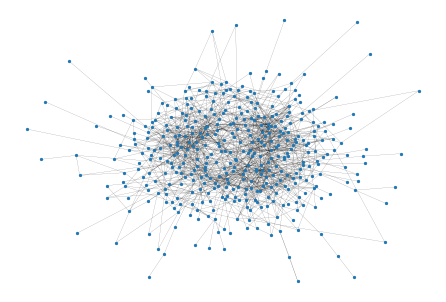

In [3]:
# Create network

DataS1.time= (DataS1.time-1)//192
network = DataS1[DataS1.meters <= 4].copy()
weighted_edges= network.groupby(['s','t','time']).\
    count().\
    unstack().\
    notnull().\
    sum(axis=1)
# maak het netwerk  
G= nx.Graph()
G.add_weighted_edges_from((k[0],k[1],v) for (k,v) in weighted_edges.iteritems())
G.name='Hasslemere'
nx.draw_kamada_kawai(G,node_size=5, width=.1);

G.number_of_nodes(),G.number_of_edges(), nx.number_connected_components(G)

# Simulate infection in network

We doen dit als volgt:

* **Input**
    * netwerk
    * verzameling start geinfecteerden
    * kans alpha op besmetting bij 1 contect
    * hoe lang je besmettelijk blijft
    * aantal tijdseenheden dat we gaan runnen
* **Algorithme**
* voor elk tijdstip, zolang er nog besmettelijke knopen zijn:
    * voor elke bemettelijke knoop:
        * voor elke buur van die knoop:
            * als die buur vatbaar is (=niet zelf besmettelijk of al immuum)
            * voor elke keer dat die knoop die buur ziet (het gewicht van de lijn):
                * knoop besmet buur met kans alpha
    * update wie nog besmettelijk is
    
## Uitbreidingen

1. Nu zijn mensen meteen besmettelijk, we kunnen ook een vertraging inbouwen.
2. In elke ronde zie je al je buren weight keer. Dat is wat veel allicht. We kunnen dit controleren:
    * Bijvoorbeeld, iedereen heeft elk tijdstip, X % van zijn gewogen degree aan contacten.
    * Die deelverzameling kan je dan random kiezen (en daarbij nog varieren wie je meeneemt in die keuze)
    

In [4]:
# 3 hulpfuncties

def immuum(Infected,t,besmettingstijd):
    '''Gegeven Infected waarin per persoon staat aangegeven op welk tijdstip die besmet is,
    wie is er immuum op tijdstip t  met gegeven besmettingstijd 
    (= hoe lang iemand ziek en besmettelijk is ( daarna is ie immuum))?'''
    return {p for p in Infected if t- Infected[p] >besmettingstijd}
    
def vatbaar(p,t,Infected, besmettingstijd):
    '''Is p vatbaar op tijdstip t gegeven Infected?'''
    return p not in (set(Infected.keys()) | immuum(Infected,t,besmettingstijd))
    
def hit(alpha):
    '''return true with chance aplha'''
    return np.random.random_sample() <= alpha

# test 
# np.array([hit(.01) for _ in range(10**6)]).sum()/10**6

In [5]:
def run(G,InitialInfected,alpha=10**-1 ,epochs=50,besmettingstijd=5):
    Infected = {p:0 for p in InitialInfected}
    log=dict()
    log[0]=(len(Infected),0,len(Infected))
    for t in range(1,epochs+1):
        Immuum= immuum(Infected,t,besmettingstijd)
        Besmettelijk= set(Infected.keys()) - Immuum
        if Besmettelijk: # simply stop if there are no more infectious nodes
            # logbook
            log[t]= (len(Besmettelijk),len(Immuum),len(Infected))
            # ga besmetten
            for n in Besmettelijk:
                for buur in G[n]:
                    if vatbaar(buur,t,Infected,besmettingstijd):
                        gewicht= G[n][buur]['weight']
                        for _ in range(gewicht): # voor elke dag contact is er een kans
                            if hit(alpha):
                                Infected[buur]=t 
    logdf= pd.DataFrame.from_dict(log, orient='index')#/len(G)
    logdf.columns=['Besmettelijk','Immuum','Infected']
    return logdf, Infected
                    

In [6]:
def run_and_plot(G,InitialInfected,alpha=10**-1,
                 epochs=50,
                 besmettingstijd=5,
                 df_absolute=True):
    title='''Infectieverloop voor netwerk %s met start besmetters %s,
    besmettingskans %f en besmettingstijd %d.'''\
    % (G.name,str(InitialInfected),alpha,besmettingstijd)
    logdf,Infected =run(G,InitialInfected,alpha ,epochs,besmettingstijd)
    if not df_absolute:
        logdf=logdf/len(G)
    logdf.plot(title=title);
    return logdf,Infected

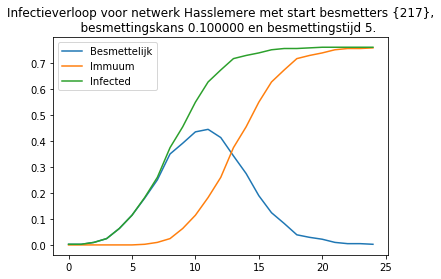

In [7]:
A,B=run_and_plot(G,{217},10**-1,df_absolute=False)

In [8]:
# percentages per tijdstip
A*100

Besmettelijk     Immuum   Infected
0       0.242718   0.000000   0.242718
1       0.242718   0.000000   0.242718
2       0.970874   0.000000   0.970874
3       2.427184   0.000000   2.427184
4       6.310680   0.000000   6.310680
5      11.407767   0.000000  11.407767
6      17.961165   0.242718  18.203883
7      25.000000   0.970874  25.970874
8      34.951456   2.427184  37.378641
9      39.077670   6.310680  45.388350
10     43.446602  11.407767  54.854369
11     44.417476  18.203883  62.621359
12     41.262136  25.970874  67.233010
13     34.223301  37.378641  71.601942
14     27.427184  45.388350  72.815534
15     18.932039  54.854369  73.786408
16     12.378641  62.621359  75.000000
17      8.252427  67.233010  75.485437
18      3.883495  71.601942  75.485437
19      2.912621  72.815534  75.728155
20      2.184466  73.786408  75.970874
21      0.970874  75.000000  75.970874
22      0.485437  75.485437  75.970874
23      0.485437  75.485437  75.970874
24      0.242718  75.728155  75.970874

In [9]:
# B geeft aan wanneer een knoop geinfecteerd is

list(B.items())[:10]

[(217, 0),
 (83, 1),
 (230, 1),
 (393, 1),
 (166, 2),
 (276, 2),
 (330, 2),
 (163, 2),
 (380, 2),
 (109, 2)]

# Robuustheid

* Laten we eens kijken hoe robuust de simulaties zijn.
* We draaien 10 keer een experiment met startknoop 217, en 30 keer met knoop 2
    * We tellen steeds het aantal besmette personen na een hele run
* Het lijkt ontzettend stabiel.

In [25]:
%%time

exps = np.array([len(run(G,{217},10**-1)[1]) for _ in range(10) ])

print(pd.Series(exps).describe())

count     10.000000
mean     333.600000
std        8.896941
min      319.000000
25%      327.500000
50%      332.500000
75%      341.500000
max      346.000000
dtype: float64
CPU times: user 3.65 s, sys: 44.7 ms, total: 3.69 s
Wall time: 3.81 s


In [11]:
%%time

exps = np.array([len(run(G,{2},10**-1)[1]) for _ in range(30) ])

print(pd.Series(exps).describe())

count     30.000000
mean     331.066667
std        6.972524
min      316.000000
25%      327.250000
50%      330.500000
75%      336.000000
max      346.000000
dtype: float64
CPU times: user 10.3 s, sys: 43.3 ms, total: 10.3 s
Wall time: 10.4 s


In [12]:
np.median(exps)

330.5

# Wie is de meest gevaarlijke knoop?

* Voor elke knoop draaien we 5 experimenten, 
    * en nemen het mediaan aantal geinfecteerden.
* Die ordenen we dan.
* Ga maar even koffie drinken ;-)

### Uitkomst

* We zien een heel duidelijke bimodale verdeling.
* Knopen zijn of helemaal niet gevaarlijk, of kunnen rond de 335 knopen besmetten.
* Geen enkele knoop besmet het hele netwerk.
* Ook de top 3 lijkt eigenlijk hetzelfde subnetwerk te besmetten.
* De besmettingsduur verlengen helpt wel!

In [13]:
%%time
aantal=5

Exps=dict()
c=0
for n in G:
    exps=  [len(run(G,{n},10**-1)[1]) for _ in range(aantal) ]
    aantal_geinfecteerden= np.median(exps  )
    Exps[n]=aantal_geinfecteerden
    c+=1
    if c%100==0:print(c)

100
200
300
400
CPU times: user 9min 15s, sys: 2.26 s, total: 9min 18s
Wall time: 9min 25s


In [14]:
pd.Series(Exps).sort_values(ascending=False)    

229    345.0
455    344.0
337    343.0
277    342.0
153    342.0
       ...  
6        1.0
140      1.0
143      1.0
249      1.0
241      1.0
Length: 412, dtype: float64

count    412.000000
mean     277.390777
std      121.845901
min        1.000000
25%      325.000000
50%      330.000000
75%      334.000000
max      345.000000
dtype: float64

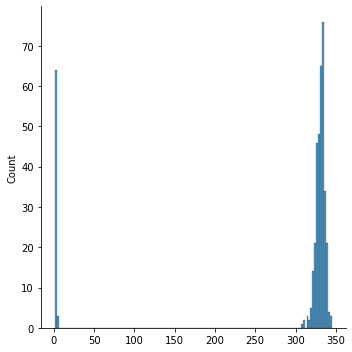

In [15]:
sns.displot(pd.Series(Exps));
pd.Series(Exps).describe()

In [16]:
# Hoeveel knopen (van de 412) kunnen de top 3 besmetters besmetten?
[len(run(G,{58,392,401},10**-1)[1]) for _ in range(5) ]

[331, 331, 328, 342, 332]

In [17]:
# Hoeveel knopen (van de 412) kunnen de top 3 besmetters besmetten?
# als we mensen 10 in plaats van 5 dagen besmettelijk houden?
# gaat omhoog, maar we kunnen net zo goed met 1 iemand beginnen

print([len(run(G,{58,392,401},10**-1, besmettingstijd=10)[1]) for _ in range(5) ])

print([len(run(G,{58 },10**-1, besmettingstijd=10)[1]) for _ in range(5) ])

print([len(run(G,{58 },10**-1, besmettingstijd=20)[1]) for _ in range(5) ]) # nog langer ziek (en besmettelijk)

[378, 366, 372, 373, 382]
[380, 374, 379, 383, 375]
[401, 402, 398, 399, 398]


# Reproductiegetal

* Zie <https://decorrespondent.nl/11149/dit-is-het-belangrijkste-getal-van-deze-epidemie-hoe-wordt-het-berekend/2818198230375-ae617b76>
* R is het **gemiddeld** aantal mensen dat 1 besmet iemand besmet


### Hoe bereken je R

De R wordt beïnvloed door drie factoren:
Zie de briefing van Jaap van Dissel op 25 maart.

1. De kans dat iemand een ander besmet bij contact (p)
2. De hoeveelheid contacten per tijdseenheid (c)
3. De duur van besmettelijkheid (d)

**Vermenigvuldig je die drie met elkaar, dan krijg je de R**

### Per experiment

* Hou bij wie wie infecteerd.
* Neem dan het gemiddelde.
* Dat cijfer is dan heel erg afhankelijk van het experiment.

In [18]:
alpha=.1 # boven is dat p
# c voor knoop n is de gewogen degree van n 
#     gedeeld door het aantal dagen dat we telden (=3)
c=np.mean([sum(G[n][b]['weight']/3 for b in G[n] )  for n in G] )
print(c)
d=5

R= alpha*c*d
R

2.622977346278317


1.3114886731391584

In [19]:
# Per experiment
# In HasInfected houden we bij wie wie infecteerd

def run_with_infected(G,InitialInfected,alpha=10**-1 ,epochs=50,besmettingstijd=5):
    Infected = {p:0 for p in InitialInfected}
    log=dict()
    log[0]=(len(Infected),0,len(Infected))
    HasInfected={n:set() for n in G} # key is node, value is the set of nodes infected by node
    for t in range(1,epochs+1):
        Immuum= immuum(Infected,t,besmettingstijd)
        Besmettelijk= set(Infected.keys()) - Immuum
        if Besmettelijk: # simply stop if there are no more infectious nodes
            # logbook
            log[t]= (len(Besmettelijk),len(Immuum),len(Infected))
            # ga besmetten
            for n in Besmettelijk:
                for buur in G[n]:
                    if vatbaar(buur,t,Infected,besmettingstijd):
                        gewicht= G[n][buur]['weight']
                        for _ in range(gewicht): # voor elke dag contact is er een kans
                            if hit(alpha):
                                Infected[buur]=t 
                                HasInfected[n]= HasInfected[n] | {buur}
    HasInfected={n:HasInfected[n] for n in Infected} # Only keep the Infected nodes in Hasinfected
    logdf= pd.DataFrame.from_dict(log, orient='index')#/len(G)
    logdf.columns=['Besmettelijk','Immuum','Infected']
    return logdf, Infected, HasInfected    
     
    
    
def ReproductieGetal(G,InitialInfected,alpha=10**-1,
                 epochs=50,
                 besmettingstijd=5):
    HasInfected= run_with_infected(G,InitialInfected,alpha ,
                 epochs ,
                 besmettingstijd )[2]
    return pd.Series([len(v) for v in HasInfected.values()])

R is het gemiddelde aantal besnettingen:  0.9969512195121951
count    328.000000
mean       0.996951
std        1.499232
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max       10.000000
dtype: float64


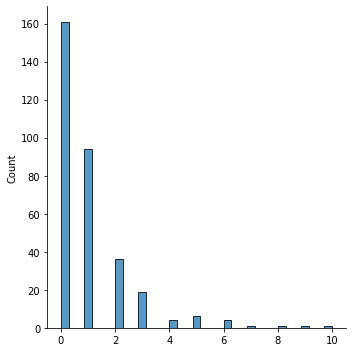

In [33]:
Besmettingen= ReproductieGetal(G,{217},.1)

print('R is het gemiddelde aantal besnettingen: ', Besmettingen.mean() )

print(Besmettingen.describe())


# aantal mensen dat x-as mensen besmet
sns.displot(Besmettingen);

In [29]:
# En hier de R over iedereen die minstens 1 iemand besmet heeft
Besmettingen[Besmettingen>0].describe()



count    173.000000
mean       1.947977
std        1.671463
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       15.000000
dtype: float64

# Waarom dat verschil?

* Waarom ligt de R met de formule van het RIVM zoveel hoger dan de R die wij in ons experiment zien?
* Terwijl we dezelfde waardes gebruiken.

### Antwoord

* Wij hebben een erg kleine populatie, en je ziet dus dat er al snel niet veel mensen meer te besmetten zijn.
* In zekere zin bereiken we de rand van het netwerk erg snel.

## R door de tijd

### Dit is een "andere R": het gemiddeld aantal besmettingen per persoon *per tijdstip*

(de normale R telt dat per persoon, over alle tijdstippen)

* Voor 1 experiment
* We delen per tijdstip steeds het aantal nieuw geinfecteerden door het aantal besmettelijken.
* We gebruiken daarvoor heel handig `df.diff()`
* De R schommelt nogal, en daarom nemen we het `rolling average` over steeds 5 tijdstippen.

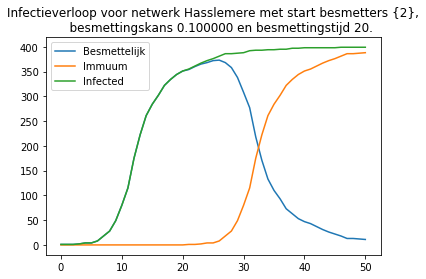

In [34]:
df=run_and_plot(G,{2},.1,besmettingstijd=20)[0]  # mensen zijn langer besmettelijk


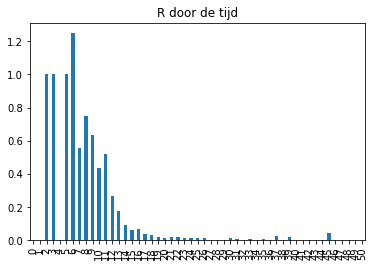

In [35]:
Rdoordetijd=(df.Infected.diff(-1).abs()/df.Besmettelijk)
Rdoordetijd.plot(kind='bar',title='R door de tijd');

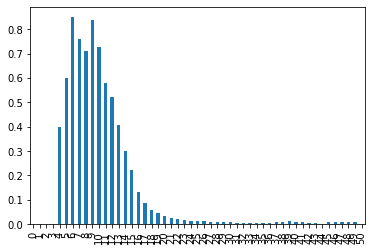

In [36]:
Rdoordetijd.rolling(5).mean().plot(kind='bar' );

# Meer normale R door de tijd

* Bereken voor elk moment t 
    * het gemiddeld aantal geinfecteerden, geinfecteerd door de mensen die zelf op tijdstip t besmet werden

In [51]:
logdf, Infected, HasInfected    = run_with_infected(G, {2})

In [54]:
Infected[2], HasInfected[2]

(0, {128, 215, 387})

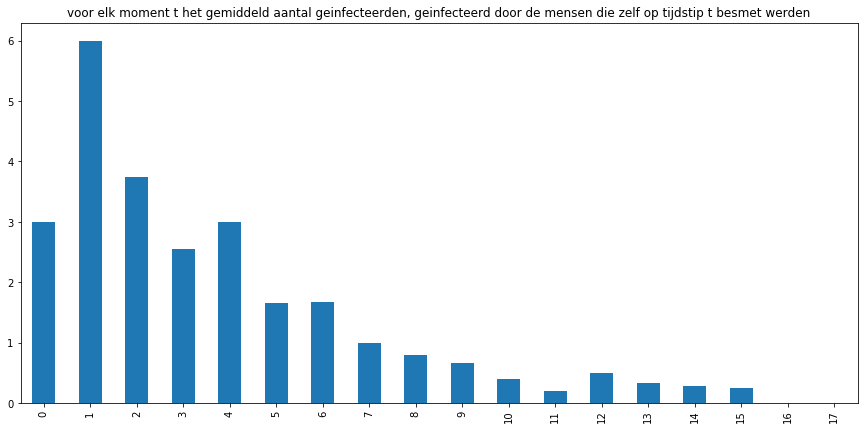

In [53]:
InvertedInfected= defaultdict(list) # geeft nu voor elk tijdstip wie er dan allemaal geinfecteerd zijn

for knoop,tijd in Infected.items():
    InvertedInfected[tijd].append(knoop)
    
InvertedInfected  

Rdoordetijd={tijd:
                sum(len(HasInfected[n]) for n in InvertedInfected[tijd]) # het totaal aantal geinfecteerden 
                /
                 len(InvertedInfected[tijd]) # het aantal mensen die  op tijdstip t geinfecteerd zijn
            for tijd in InvertedInfected
            }

pd.Series(Rdoordetijd).plot(kind='bar', figsize=(15,7),
                            title='voor elk moment t het gemiddeld aantal geinfecteerden, geinfecteerd door de mensen die zelf op tijdstip t besmet werden');